#MODELING SCALED OFFENSIVENESS IN GREEK TEXTS THROUGH REGRESSION WITH BEST0WORST SCALING AND PRETRAINED MODELS

#National and Kapodistrian University of Athens

#Department of Informatics and Telecommunications

#Program of Postgraduate Studies: (M.Sc.) in Language Technology

#Master's Thesis


#Balas Antonis (lt12100021)



In [ ]:
# Importing required libraries
import json
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Defining the folder path where the model statistics are stored
folder = "/content/drive/MyDrive/MODELS/Regression/Best_Models/all/BERT/nlpaueb-bert-base-greek-uncased-v1/"

# Constructing the full path to the JSON file that contains training/evaluation statistics
file_dest = f"{folder}statistics_per_epoch.json"

# Opening the JSON file and loading its contents into the variable 'data'
with open(file_dest, 'r') as f:
  data = json.load(f)

In [ ]:
# Initializing a list to hold results from each epoch
results_per_epoch = []

# Iterating over the values (per-epoch stats) in the loaded JSON data
for stat in data.values():
  # Converting each epoch's stats into a DataFrame
  df = pd.DataFrame(stat)
  # Appending the DataFrame to the results list
  results_per_epoch.append(df)

In [ ]:
# Function to compute Root Mean Squared Error (RMSE)
def rmse(actual_values, predictions):
  # Calculating the Mean Squared Error (MSE)
  mse = mean_squared_error(actual_values, predictions)
  # Returning the square root of MSE, which is RMSE
  return sqrt(mse)

# Function to compute Relative Squared Error (RSE)
def rse(actual_values, predictions):
  # Calculating the Residual Sum of Squares (RSS)
  rss = sum((actual_values - predictions) ** 2)
  # Returning the square root of normalized RSS
  return sqrt(rss / (len(actual_values) - 2))


# Custom implementation of Huber loss using PyTorch and pandas inputs
class myHuberLoss(nn.HuberLoss):
  def forward(self, input: pd.Series, target: pd.Series) -> list:
    # Converting pandas Series to lists, then to PyTorch tensors
    input = input.tolist()
    target = target.tolist()
    input_tensor = torch.tensor(input, dtype=torch.float)
    target_tensor = torch.tensor(target, dtype=torch.float)
    # Calling the parent HuberLoss forward method
    output_tensor = super().forward(input_tensor, target_tensor)
    # Returning the loss as a float
    return float(output_tensor)

# Function to return the Huber loss function instance
def loss_function(delta=1.):
  my_loss = myHuberLoss(delta=delta)
  return my_loss

In [ ]:
# List of evaluation metric functions to be applied during model evaluation
metrics_functions = [mean_squared_error, r2_score, rmse, rse, loss_function(1.)]

In [ ]:
# Dictionaries to store evaluation results for seen (training) and unseen (validation) data per epoch
seen = {}
unseen = {}

# Iterating over each epoch's results
for step, epoch in enumerate(results_per_epoch):
  seen[step] = []
  unseen[step] = []

  # Splitting the data into training and validation (seen/unseen) sets
  seen_data_df = epoch[epoch['Training'] == True]
  unseen_data_df = epoch[epoch['Training'] == False]

  # Applying each metric to both seen and unseen data
  for func in metrics_functions:
    # Evaluating performance on training data
    seen[step].append(func(seen_data_df['BWS'], seen_data_df['Prediction']))
    # Evaluating performance on validation data
    unseen[step].append(func(unseen_data_df['BWS'],
                             unseen_data_df['Prediction']))


In [ ]:
# Converting the dictionaries (which have metrics per epoch) into DataFrames
seen_st_df = pd.DataFrame(seen)
unseen_st_df = pd.DataFrame(unseen)

# Defining mapping from numeric index to metric names
index_mapping = {0: 'MSE', 1: 'R_Squared', 2: "RMSE", 3: 'RSE', 4: 'Loss'}

# Renaming the index of the DataFrames using the defined metric names
seen_st_df.rename(index=index_mapping, inplace=True)
unseen_st_df.rename(index=index_mapping, inplace=True)

# Printing the metrics for seen and unseen data per epoch
print(seen_st_df)
print('-'*15)
print(unseen_st_df)

                 0         1         2         3         4         5   \
MSE        0.045518  0.033899  0.027570  0.025724  0.024141  0.023306   
R_Squared  0.079581  0.314531  0.442507  0.479840  0.511836  0.528720   
RMSE       0.213349  0.184116  0.166042  0.160386  0.155375  0.152664   
RSE        0.213371  0.184135  0.166059  0.160403  0.155391  0.152680   
Loss       0.022759  0.016949  0.013785  0.012862  0.012071  0.011653   

                 6         7         8         9         10        11  \
MSE        0.022279  0.022043  0.021862  0.021327  0.020850  0.020520   
R_Squared  0.549489  0.554272  0.557930  0.568740  0.578381  0.585071   
RMSE       0.149263  0.148468  0.147858  0.146039  0.144397  0.143247   
RSE        0.149278  0.148484  0.147873  0.146054  0.144412  0.143262   
Loss       0.011140  0.011021  0.010931  0.010664  0.010425  0.010260   

                 12        13        14        15        16        17  \
MSE        0.020405  0.020395  0.020114  0.019681

In [ ]:
# Finding the epoch (column index) where MSE is minimized in the training set
min_column_seen = seen_st_df.loc['MSE'].idxmin()
# Finding the minimum MSE value in the training set
min_value_seen = seen_st_df.loc['MSE'].min()

# Finding the epoch (column index) where MSE is minimized in the evaluation (unseen) set
min_column_unseen = unseen_st_df.loc['MSE'].idxmin()
# Finding the minimum MSE value in the evaluation set
min_value_unseen = unseen_st_df.loc['MSE'].min()


# Printing results with nicely formatted output
print(f'Training   Best Epoch: {min_column_seen+1:2} value: {min_value_seen:.3}')
print(f'Evaluation Best Epoch: {min_column_unseen+1:2} ' +
      f'value: {min_value_unseen:.3}')

Training   Best Epoch: 18 value: 0.0195
Evaluation Best Epoch: 20 value: 0.0199


In [ ]:
# Getting the DataFrame corresponding to the best epoch based on training MSE
best_epoch_df = results_per_epoch[min_column_seen]

# Inserting a new column 'Deviation' at index 3
# This column contains the absolute difference between the actual BWS and the model's prediction
best_epoch_df.insert(3, 'Deviation',
                     np.abs(best_epoch_df['BWS'] - best_epoch_df['Prediction']),
                     True)
# Displaying the first few rows of the DataFrame
best_epoch_df.head()

,Text,BWS,Prediction,Deviation,Training
0,"κερναμε » , απανταει ο παναγιωτης με ενα ηλιθι...",0.810000,0.666274,0.143726,True
1,η αγγλια οπου η φωλια του 1 % που φυλαει τα αρ...,0.450000,0.741766,0.291766,True
2,η kaylah μπορεσε να επιστρεψει στο σπιτι μετα ...,0.391304,0.191550,0.199754,True
3,"αυτος φωναζε ο αχρηστος , γιατι δε βρηκε ετοιμ...",0.580000,0.613269,0.033269,True
4,"αν πω πως τον αγαπουσα , θα "" λεγα ψεματα .",0.310000,0.307318,0.002682,True


from matplotlib import pyplot as plt
_df_0['BWS'].plot(kind='hist', bins=20, title='BWS')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Prediction'].plot(kind='hist', bins=20, title='Prediction')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Deviation'].plot(kind='hist', bins=20, title='Deviation')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('Text').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='BWS', y='Prediction', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='Prediction', y='Deviation', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6['BWS'].plot(kind='line', figsize=(8, 4), title='BWS')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_7['Prediction'].plot(kind='line', figsize=(8, 4), title='Prediction')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_8['Deviation'].plot(kind='line', figsize=(8, 4), title='Deviation')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_9['Text'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_9, x='BWS', y='Text', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_10['Text'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_10, x='Prediction', y='Text', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_11['Text'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_11, x='Deviation', y='Text', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
#best_epoch_df
best_epoch_df.to_excel(f"{folder}best_statistics.xlsx", index=False)

In [ ]:
# Training Set
min_deviation_seen = best_epoch_df[best_epoch_df['Training'] == True]['Deviation'].min()
max_deviation_seen = best_epoch_df[best_epoch_df['Training'] == True]['Deviation'].max()
mean_deviation_seen = best_epoch_df[best_epoch_df['Training'] == True]['Deviation'].mean()

# Evaluation Set
min_deviation_unseen = best_epoch_df[best_epoch_df['Training'] == False]['Deviation'].min()
max_deviation_unseen = best_epoch_df[best_epoch_df['Training'] == False]['Deviation'].max()
mean_deviation_unseen = best_epoch_df[best_epoch_df['Training'] == False]['Deviation'].mean()

print('Training Statistics - Deviation')
print(f'Min value: {min_deviation_seen:.3}, Max value: {max_deviation_seen:.3}, Mean value: {mean_deviation_seen:.3}')

print('Evaluation Statistics - Deviation')
print(f'Min value: {min_deviation_unseen:.3}, Max value: {max_deviation_unseen:.3}, Mean value: {mean_deviation_unseen:.3}')

Training Statistics - Deviation
Min value: 2.51e-05, Max value: 0.642, Mean value: 0.111
Evaluation Statistics - Deviation
Min value: 1.75e-05, Max value: 0.525, Mean value: 0.111


In [ ]:
# Preparing a dictionary with all relevant statistics to save


general_statistics = {
    'Entirely Statistics': {
        'Training': seen_st_df.T.to_dict(),           # All training metrics across epochs
        'Evaluation': unseen_st_df.T.to_dict()        # All evaluation metrics across epochs
    },
    'Best': {
        'Training': {
            'Epoch': int(min_column_seen),        # Corresponding MSE value
            'Value': float(min_value_seen)
          },
        'Evaluation': {
            'Epoch': int(min_column_unseen),     # Best evaluation epoch based on MSE
            'Value': float(min_value_unseen)     # Corresponding MSE value
          }
        },
    'Deviation Data': best_epoch_df.to_dict(),     # Deviation values for best epoch (seen & unseen)
    'Deviation Statistics': {
        'Training': {
            'Max': float(max_deviation_seen),
            'Min': float(min_deviation_seen),
            'Mean': float(mean_deviation_seen)
        },
        'Evaluation': {
            'Max': float(max_deviation_unseen),
            'Min': float(min_deviation_unseen),
            'Mean': float(mean_deviation_unseen)
        },
    },
  #  'Threshold Data': {
  #    'Training': training_threshold_stats.to_dict(),
  #      'Evaluation': evaluation_threshold_stats.to_dict()
    }

# Defining the path to save the JSON statistics file
file_input = f'{folder}general_statistics.json'


# Writing the dictionary to a JSON file
with open(file_input, 'w') as f:
  json.dump(general_statistics, f)

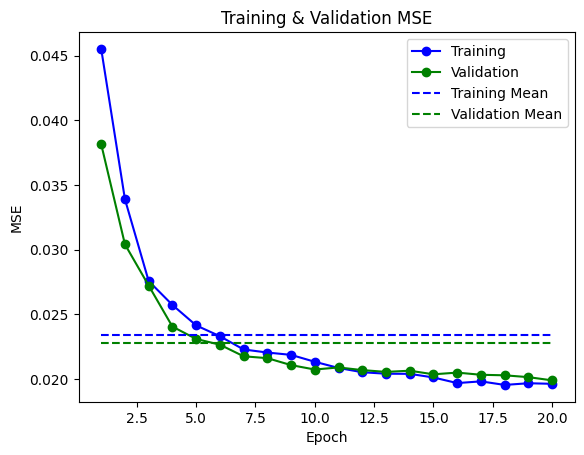

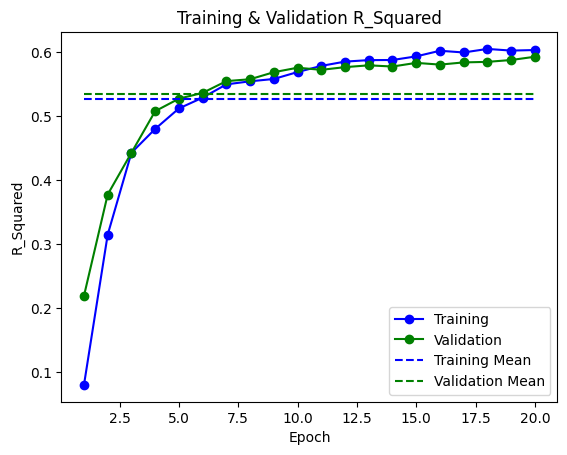

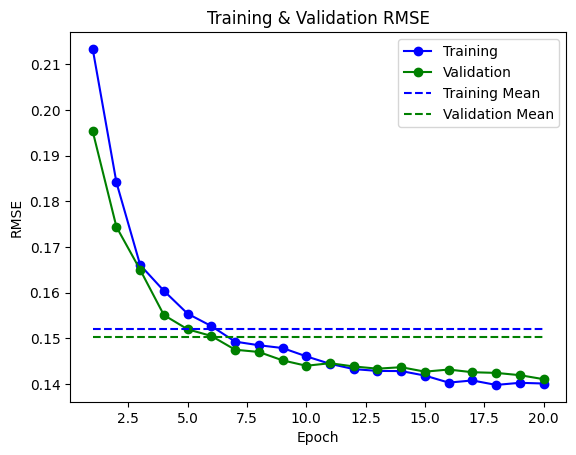

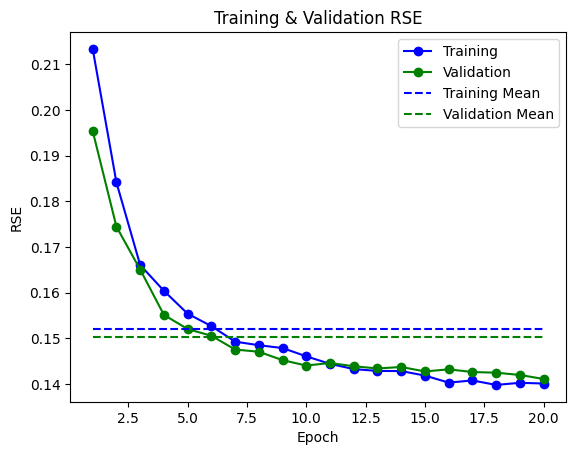

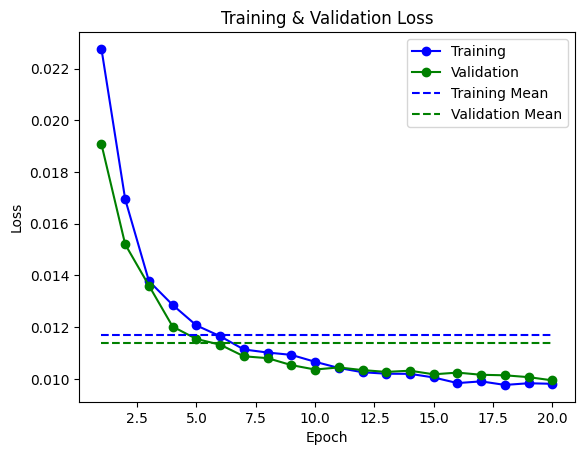

In [ ]:
# Defining the x-axis as the number of epochs
x_axis = range(1, len(seen_st_df.T)+1)

# Iterating through each metric
for metric in seen_st_df.T:
  plt.figure()
  # Plotting metric values across epochs for training data
  plt.plot(x_axis, seen_st_df.T[metric], 'b-o', label='Training')
  # Plotting metric values across epochs for validation data
  plt.plot(x_axis, unseen_st_df.T[metric], 'g-o', label='Validation')

  # Adding mean line for training data
  mean = [seen_st_df.T[metric].mean() for _ in range(len(seen_st_df.T))]
  plt.plot(x_axis, mean, 'b--', label='Training Mean')

  # Adding mean line for validation data
  mean = [unseen_st_df.T[metric].mean() for _ in range(len(unseen_st_df.T))]
  plt.plot(x_axis, mean, 'g--', label='Validation Mean')

  # Plotting title and axis labels
  plt.title(f'Training & Validation {metric}')
  plt.xlabel('Epoch')
  plt.ylabel(metric)

  # Display legend
  plt.legend()
  # Saving the plot to the output folder with the metric name as filename
  plt.savefig(f"{folder}{metric}")